In [1]:
%matplotlib inline
import numpy as np
import scipy
import pandas
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.width', 350)

//miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import json
import statistics
import urllib
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [19]:
def parse_json(data):
    """ function to parse json data """
    session_id = []
    timestamp = []
    cities = []
    user_id = []
    joining_date = []
    country = []
    
    # parse each item
    for item in data:
        session_id.append(item['session_id'][0])
        timestamp.append(item['unix_timestamp'][0])
        cities.append(item['cities'][0])
        user_id.append(item['user'][0][0]['user_id'])
        joining_date.append(item['user'][0][0]['joining_date'])
        country.append(item['user'][0][0]['country'])
    
    # create DataFrame
    maps = {'session_id': session_id, 'timestamp': timestamp, 'cities': cities, 
            'user_id': user_id, 'joining_date': joining_date, 'country': country}
    columns=['session_id', 'timestamp', 'cities', 'user_id', 'joining_date', 'country']
    
    return pandas.DataFrame(maps, columns=columns)

In [20]:
with open('./dataset/city_searches.json', 'r') as f:
    json_data = json.load(f)

data = parse_json(json_data)
data['joining_date'] = pandas.to_datetime(data['joining_date'])

In [21]:
data.head()

,session_id,timestamp,cities,user_id,joining_date,country
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US


In [42]:
data[data['country'] == ''].size

19383

In [22]:
data['country'].value_counts()

US    3772
UK    3754
DE    3741
      2769
FR    2341
IT    1843
ES    1802
Name: country, dtype: int64

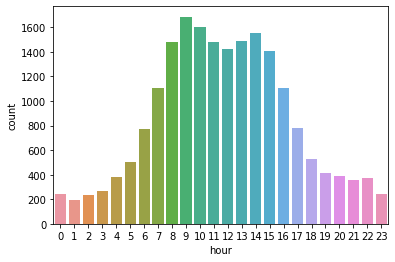

In [23]:
#Let's extract hour of the day from timestamp. This will be our x-axis in the distribution plot
#make it a time
data['timestamp']=pandas.to_datetime(data['timestamp'], unit='s')
#extract hour
data['hour']=data['timestamp'].apply(lambda x: x.hour)
sns.countplot(x='hour', data=data)

Overall, peak time is during 7AM-4PM UTC time: it looks like the high majority of the customer base is based in Europe. Let’s now check by country:

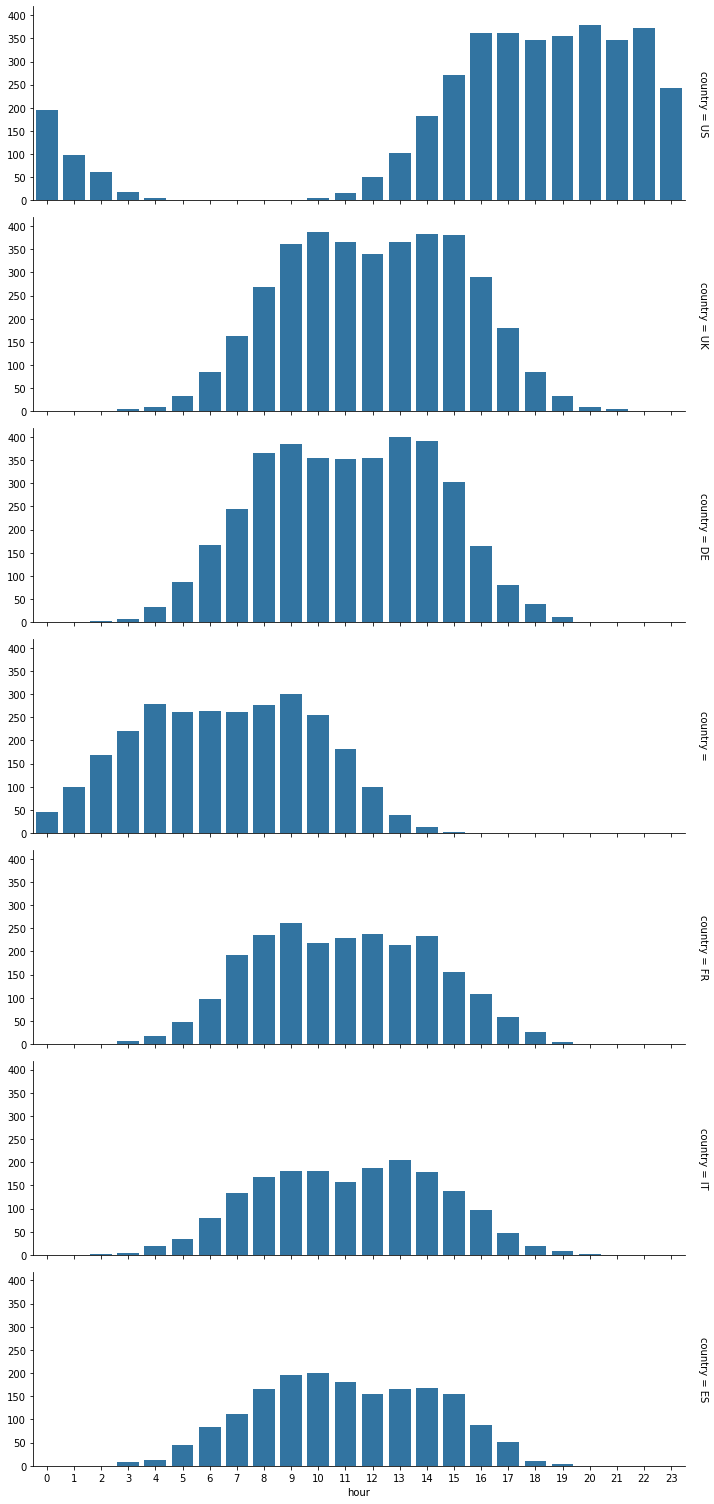

In [26]:
g = sns.FacetGrid(data, row="country", row_order=data.country.value_counts().index, margin_titles = True)
g.fig.set_figwidth(10)
g.map(sns.countplot,'hour', order = range(24))

Western European countries like Germany, Spain, etc. are pretty consistent in having peak hours for traffic approximately between 8 and 15. Missing country seems to be shifted to the left (aka east) by 4 hours or so. It is most likely a country within the Middle East, Russia, or Pakistan.

# For each city, find the most likely city also searched for within the same session.

In [27]:
#Let's create a vector of all cities searched for in the same order as the original dataset
cities = data['cities'].str.split(", ")
cities= np.hstack(cities)
#Then, for each session_id let's get count of cities searched together
count_per_session = data['cities'].apply(lambda x: len(x.split(',')))
#Let's create a vector where each session is repeated as many times as count_per_session
session_id = np.repeat(data['session_id'], count_per_session)
#Put them into a data.frame

In [28]:
data_similarity = pandas.DataFrame({'cities':cities, 'session_id':session_id})

In [29]:
data_similarity.head()

,cities,session_id
0,San Jose CA,D258NVMV202LS
0,Montreal QC,D258NVMV202LS
1,New York NY,TDG10UKG7I4LR
2,Montreal QC,OH4ZDIGN9BLQS
2,Quebec QC,OH4ZDIGN9BLQS


In [30]:
#Now this is in long format. We need to make it wide, with each row a session, each column a possible city, and values 0/1 if that city was searched in that session
data_similarity['binary_value'] = 1
data_similarity = data_similarity.pivot(index='session_id', columns='cities').fillna(0)

In [31]:
data_similarity.shape

(20022, 87)

In [33]:
data_similarity.head(1)

binary_value                                                                                                              ...                                                                                                                       
cities          Anaheim CA Arlington TX Atlanta GA Austin TX Bakersfield CA Baltimore MD Birmingham AL Boston MA Buffalo NY Calgary AB  ... Toledo OH Toronto ON Tucson AZ Tulsa OK Vancouver BC Victoria BC Virginia Beach VA WASHINGTON DC Wichita KS Windsor ON
session_id                                                                                                                              ...                                                                                                                       
005DKBSO9FEZL          0.0          0.0        0.0       0.0            0.0          1.0           0.0       0.0        0.0        0.0  ...       0.0        0.0       0.0      0.0          0.0         0.0               0.0           0.0        0.0        0.0

[1 rows x 87 columns]

In [35]:
from sklearn import metrics
 
#As similarity function, let's take the cosine similarity
city_cosine = pandas.DataFrame(metrics.pairwise.cosine_similarity(data_similarity.T))
#add index and column names 
city_cosine.columns = data_similarity.columns.get_level_values(1)
city_cosine.index = city_cosine.columns
  
#Let's now find for each row/city, the column with the highest value (after excluding that city itself)
closest_city = pandas.DataFrame({"most_similar_city":[None]*len(city_cosine)})
#Let's have cities as index
closest_city.index = city_cosine.index
  
#For each row, we pick the highest score
i = 0
while i < len(closest_city):
      #for each city, this gives a list of cosine similarity with the other cities
      tmp_cosine = city_cosine.drop(city_cosine.columns[i], axis=1).iloc[i]
      #and now we pick the city with the max
      closest_city.most_similar_city.iloc[i] = tmp_cosine.idxmax()
      i += 1
  
#They tend to make sense
print(closest_city.head(10))

                          most_similar_city
cities                                     
Anaheim CA                     Santa Ana CA
Arlington TX                  Fort Worth TX
Atlanta GA                    Birmingham AL
Austin TX                    San Antonio TX
Bakersfield CA                    Fresno CA
Baltimore MD                  WASHINGTON DC
Birmingham AL                    Atlanta GA
Boston MA                    Jersey City NJ
Buffalo NY      Saint Catharines-Niagara ON
Calgary AB                      Edmonton AB


# Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation.Come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way

There are a couple of ways to define distance.
One option is to simply use actual geographical distance. We can use some map API to convert cities into lat and long and then estimate actual distance between them.
Another option is to use cosine similarity from above as a proxy for distance. The assumption here is that cities that are geographically close to each other are also more likely to be searched together because they are part of the same trip. Therefore they will have higher cosine similarity.
Another way to say this is: let’s say someone searches for San Francisco. If they are actually planning for a vacation, they will most likely also search for, say, Los Angeles. On the other hand, if they are just dreaming about a vacation, they will search for some other random cities (NY, Rome, Paris, etc.). But dreamer co-searches will be very diverse, i.e. one will search for SF and NY, one for SF and Rome, etc. On the other hand, most of trip planners will search for exactly LA and SF. Therefore, LA should have way higher cosine similarity with SF than those other cities.


We will use option 2 here. The step by step approach will be:
Remove searches with just one city. We don’t have enough info now to assign them to either low or high intent
For each of the remaining searches, we will estimate the average distance between all pairwise combinations. We use the average instead of some percentile-based metric because we want our metric to be affected by outliers. If, in a given search, there is at least one city that’s far away from the others, we want that to be a strong indicator of not being an actual trip
We will plot all the scores from point 2 and then choose a threshold to separate trip planners from dreamers


In [36]:
import itertools
 
#Only keep sessions with more than one search
data_intent = data['cities'][count_per_session>1].reset_index(drop=True)
 
score = []
i = 0
#loop through all the rows
while i < len(data_intent):
  #extract cities
  cities_intent  = data_intent[i].split(", ")
  #get all pairwise combinations
  cities_combinations = list(itertools.combinations(cities_intent, 2))
  #Take the mean of cosine similarity between those pairs
  pairwise_distance = []
  for j in range(len(cities_combinations)):
        pairwise_distance.append(city_cosine.loc[cities_combinations[j][0], cities_combinations[j][1]])
  score.append(statistics.mean(pairwise_distance))
  i += 1


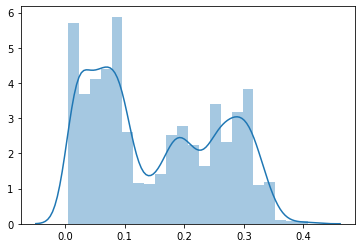

In [37]:
#Let's plot score distribution
sns.distplot(score)

We can see some sort of discontinuity around 0.1. Let’s take that as a threshold.

In [38]:
print("0.1 represents the ", round(scipy.stats.percentileofscore(score, 0.1), 1), "th ", "percentile", sep="")

0.1 represents the 43.8th percentile


That is, among people searching at least 2 cities, ~56% are actually planning a trip and ~44% don’t have high intent to book. A pretty common next step at this point could be designing different site experiences for the two groups.